In [25]:
import pandas as pd
import numpy as np
import dill as pickle

import matplotlib.pyplot as plt

from custom_thesis_functions import *

%matplotlib inline

In [27]:
instance_info = ""

In [28]:
period = pd.date_range('2017-01-01 00:00', '2017-01-07 23:45', freq='h')

# _________________________________

In [29]:
path_tmp = path_pickle_data + create_date_format(period) + '\\'

In [30]:
excelFile_dispatch_real = pd.ExcelFile(path_import_data + "DE Realisierte Erzeugung 2017.xlsx")
excelFile_demand = pd.ExcelFile(path_import_data + 'DE Realisierter Stromverbrauch 2017.xlsx')

In [31]:
df_dispatch_ee_real = pd.read_excel(excelFile_dispatch_real,sheet_name="Realisierte Erzeugung",
                                 index_col=0, header=0, usecols="A,B,C,D,E,F,G,L")
df_dispatch_fossil_real = pd.read_excel(excelFile_dispatch_real,sheet_name="Realisierte Erzeugung",
                                 index_col=0, header=0, usecols="A,H,I,J,K")

df_demand = pd.read_excel(excelFile_demand, sheet_name="mapping_demand",
                          index_col=0, header=0, usecols="A:J")

In [33]:
filename = path_tmp + "\\network" + instance_info + ".pickle"

with open((path_tmp + 'network.pickle'), 'rb') as f:
    network = pickle.load(f)

In [35]:
s_dispatch_ee_real = (df_dispatch_ee_real.replace('-',0)
                        .resample('1H').sum()
                        .agg('sum', axis='columns')
                        .loc[period])
df_dispatch_fossil_real = (df_dispatch_fossil_real.replace('-',0)
                           .resample('1H').apply(np.sum)
                           .loc[period])

df_demand = (df_demand.replace('-',0)
             .resample('1H').sum()
             .agg('sum', axis='columns')
             .loc[period])

In [36]:
df_dispatch_real = df_dispatch_fossil_real
df_dispatch_real['ee'] = s_dispatch_ee_real
df_dispatch_real.rename(columns={
    "Kernenergie[MWh]":"Kernenergie",
    "Braunkohle[MWh]":"Braunkohle",
    "Steinkohle[MWh]":"Steinkohle",
    "Erdgas[MWh]":"Erdgas",
}, inplace=True)
# df_dispatch_real.head(3)

In [37]:
colors = {"Erdgas":"orange",
          "Braunkohle":"brown",
          "Steinkohle":"black",
          "Wind":"blue",
          "ee":"green",
          "Import":"red",
          "Kernenergie":"yellow"}

In [38]:
df_dispatch_real = df_dispatch_real[["Kernenergie", "ee", "Braunkohle", "Steinkohle", "Erdgas"]]

In [39]:
df_dispatch_calculated = network.generators_t.p.groupby(network.generators.carrier, axis=1).sum()
df_dispatch_calculated[df_dispatch_calculated < 0] = 0
df_dispatch_calculated = df_dispatch_calculated[["Wind", "ee", "Braunkohle", "Steinkohle", "Erdgas", "Import"]]
# df_dispatch_calculated()

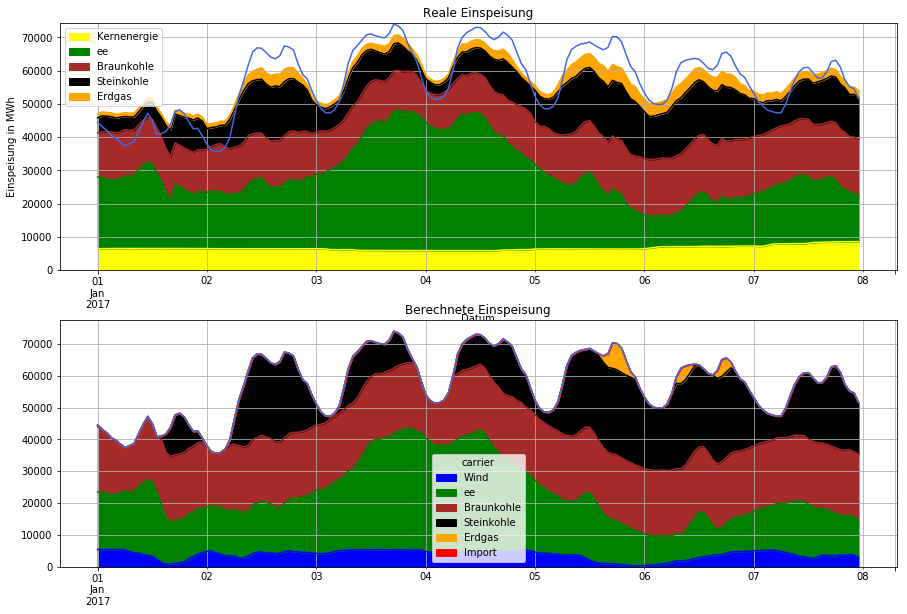

In [65]:
fig,(ax1, ax2) = plt.subplots(2,1)
fig.set_size_inches(15,10)

ax1.grid(True, which='minor')
ax1.set_xlabel("Datum")
ax1.set_ylabel("Einspeisung in MWh")
df_dispatch_real.plot(kind='area', ax=ax1, title="Reale Einspeisung", grid=True, color=[colors[i] for i in df_dispatch_real.columns])
df_demand.plot(ax=ax1, color='royalblue', grid=True)

ax2.grid(True, which='minor')
ax1.set_xlabel("Datum")
ax1.set_ylabel("Einspeisung in MWh")
df_dispatch_calculated.plot(kind='area', ax=ax2, title="Berechnete Einspeisung", color=[colors[i] for i in df_dispatch_calculated.columns])
df_demand.plot(ax=ax2, color='royalblue', grid=True)

fig.savefig(path_tmp + 'compare')

Calculate the difference for each snap for each carrier

In [41]:
df_dispatch_difference = pd.DataFrame(columns=colors.keys())

for key in colors.keys():
    if key in df_dispatch_real.columns and key in df_dispatch_calculated.columns:
#         print(type(key))
        df_dispatch_difference[key] = (df_dispatch_calculated[key] - df_dispatch_real[key])
    else:
        df_dispatch_difference[key] = 0

In [42]:
df_dispatch_difference = df_dispatch_difference[["Kernenergie", "ee", "Braunkohle", "Steinkohle", "Erdgas", "Import"]]

Aggregate wind and ee to ee for comparison

In [49]:
df_dispatch_difference["ee"] = df_dispatch_calculated.iloc[:,0:2].sum(axis=1) - df_dispatch_real['ee']

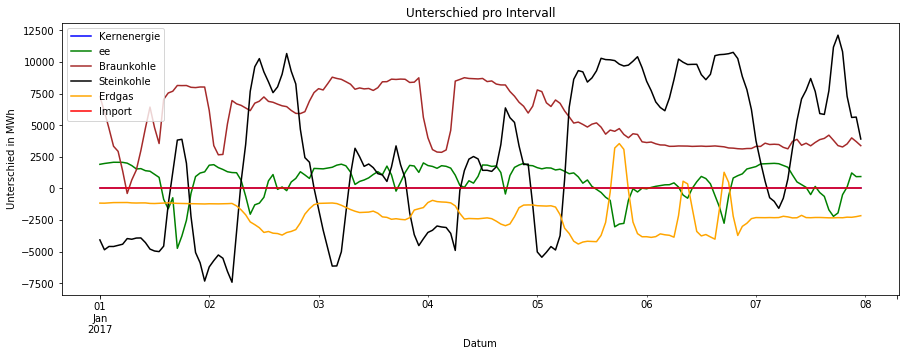

In [64]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(15,5)

ax.grid(True)
ax.set_ylabel("Unterschied in MWh")
ax.set_xlabel("Datum")
df_dispatch_difference.plot(ax=ax, title="Unterschied pro Intervall", color=[colors[i] for i in df_dispatch_calculated.columns])

fig.savefig(path_tmp + 'difference')

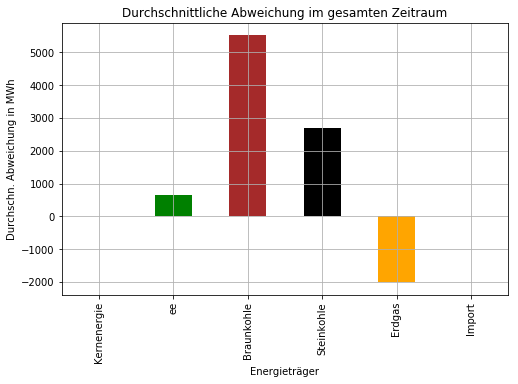

In [69]:
fig,ax = plt.subplots(1,1)
fig.set_size_inches(8,5)

ax.set_xlabel("Energieträger")
ax.set_ylabel("Durchschn. Abweichung in MWh")
df_dispatch_difference.mean().plot(kind='bar', title="Durchschnittliche Abweichung im gesamten Zeitraum", grid=True, color=[colors[i] for i in df_dispatch_calculated.columns])

fig.savefig(path_tmp + 'avg_difference')